# Моделирование
инструмент моделирования

In [1]:
from IPython.display import Image, display

In [ ]:
%load_ext autoreload 
%autoreload 2
import sys
sys.path.append('.../SDS-modelling-demo/scripts')
import scripts.data_preprocessing as preproc
import scripts.documentation as doc
import scripts.database_management as db_management
import scripts.modelling as modelling

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import sqlite3 as sql
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.integrate import simps
import glob
import optuna
from sklearn.model_selection import KFold
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')  # офнули уведы об ошибках


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [ ]:
db = db_management.database(**{
    "dbname": doc.db_database_name, 
    "user": doc.db_user_name, 
    "password": doc.db_password
})

In [4]:
grid_inst = modelling.grid(
    database=db, 
    iterations=1,
    circle_accept=3
    )  # ~ 46'' per iteration (nodes);

iteration 1 / 1
generated 1 / 96 of lines with ridge_alpha=0.04, r2=1.00, mae=423.92 (1)
generated 2 / 96 of lines with ridge_alpha=0.92, r2=1.00, mae=1.59 (1)
troubles with:
features: {'protection': '3REP', 'size': '8', 'op_type': 'read', 'hw_chassis': 'VEGMAN', 'ssd': '2'}
   nodes      target
0    4.0  10567.3150
1    6.0  13273.1910
2    8.0   3652.4075
3    8.0  17363.6150
generated 4 / 96 of lines with ridge_alpha=0.68, r2=1.00, mae=0.74 (1)
generated 5 / 96 of lines with ridge_alpha=0.51, r2=1.00, mae=62.69 (1)
generated 6 / 96 of lines with ridge_alpha=0.25, r2=1.00, mae=251.05 (1)
generated 7 / 96 of lines with ridge_alpha=0.65, r2=1.00, mae=66.50 (1)
generated 8 / 96 of lines with ridge_alpha=0.07, r2=1.00, mae=428.41 (1)
generated 9 / 96 of lines with ridge_alpha=0.40, r2=1.00, mae=1.68 (1)
generated 10 / 96 of lines with ridge_alpha=0.58, r2=1.00, mae=1770.67 (1)
generated 11 / 96 of lines with ridge_alpha=0.32, r2=1.00, mae=196.83 (1)
generated 12 / 96 of lines with ridge_

In [6]:
#grid_inst.write(method='json', validation=True)

In [27]:
len(grid_inst.lines)

111160

In [ ]:
parametr = 'nodes'
'''
It's an Ox' value
(Oy always is a target value --- perfomance)
'''
# пока строгая структура с наличем всех, кроме одного параметра
### fix other params for detail searching
fix_params_1 = {
    'protection': '*',
    'size': '*',
    'op_type': '*',
    'hw_chassis': '*',
    'ssd': '*'
}
### we can define here other pack of params for compare
fix_params_2 = {
    'protection': '*',
    'size': '*',
    'op_type': '*',
    'hw_chassis': '*',
    'ssd': '*'
}
###
grid_inst.compare_graphs(parametr=parametr, fix_params_1=fix_params_1, fix_params_2=fix_params_2)

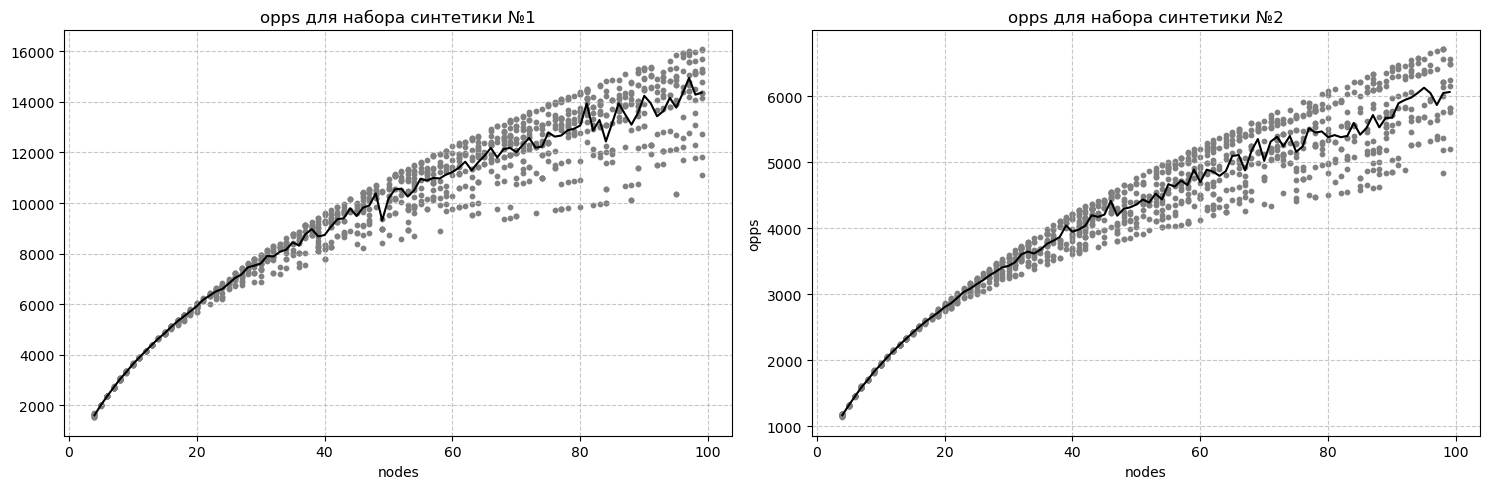

In [2]:
display(Image(filename='demo_graphs/synth_graphs.png'))

In [ ]:
parametr = 'nodes'
'''
It's an Ox' value
(Oy always is a target value --- perfomance)
'''
# пока строгая структура с наличем всех, кроме одного параметра
### fix other params for detail searching
fix_params_1 = {
    'protection': '*',
    'size': '*',
    'op_type': '*',
    'hw_chassis': '*',
    'ssd': '*'
}
### we can define here other pack of params for compare
fix_params_2 = {
    'protection': '*',
    'size': '*',
    'op_type': '*',
    'hw_chassis': '*',
    'ssd': '*'
}
###
grid_inst.compare_graphs(parametr=parametr, fix_params_1=fix_params_1, fix_params_2=fix_params_2)

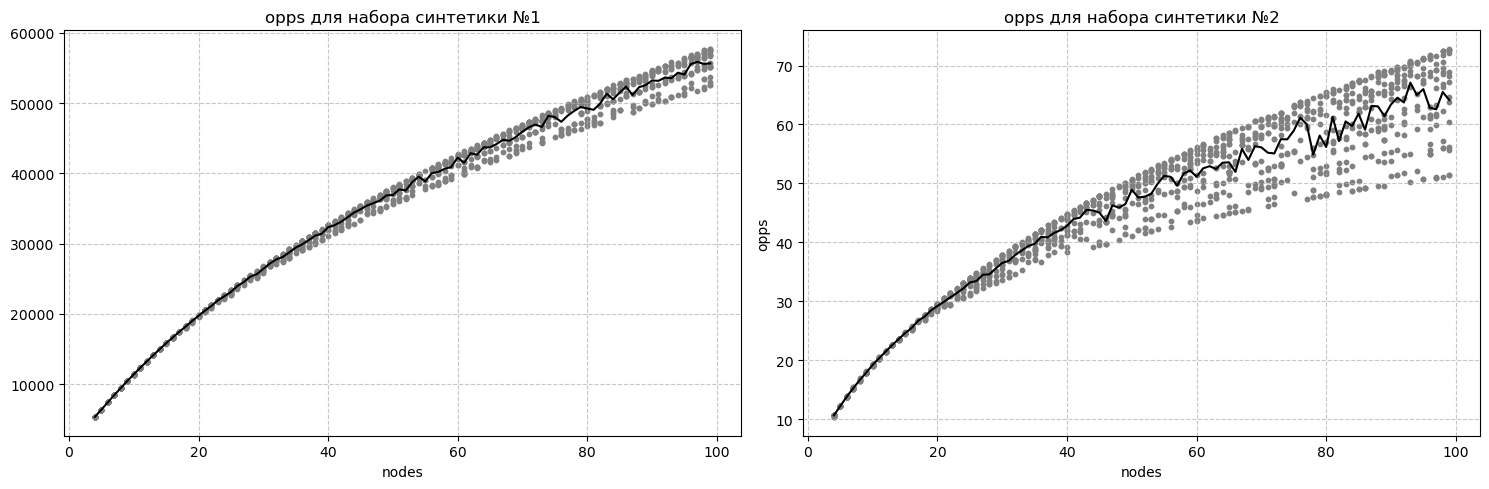

In [3]:
display(Image(filename='demo_graphs/synth_graphs_1.png'))

## Declare data

In [11]:
synth_df = pd.DataFrame(grid_inst.GET(targets=["id"] + doc.features+[doc.target], features={})[:,1:], columns=doc.features+[doc.target])
synth_df.index = np.array(grid_inst.GET(targets=["id"], features={}))[:,0]
print('synthetic df\n',synth_df.head(2))
raw_df = pd.DataFrame(db.GET(doc.features+[doc.target], {}, 'sizes'), columns=doc.features+[doc.target])
raw_df.index = list(item[0] for item in db.GET(targets=["id"], features={}, table_name='sizes'))
print('\nraw df\n',raw_df.head(2))
data_df = pd.concat([raw_df,synth_df],axis=0)
print('\nsummary df',data_df.head(2))
print(f'\nlength of all data: {len(data_df)}')


synthetic df
                                           protection size nodes op_type  \
line-67e0ed3b-cd17-4b1b-a1ee-2cc2c6bd18ba       3REP    8    20    read   
line-b7072871-c9d9-4779-86e1-0dc8ad61780c       3REP    8    42    read   

                                          hw_chassis ssd      sum_opps  
line-67e0ed3b-cd17-4b1b-a1ee-2cc2c6bd18ba       X205   0  19730.445077  
line-b7072871-c9d9-4779-86e1-0dc8ad61780c       X205   0  30702.683065  

raw df
                                      protection  size  nodes op_type  \
87b8b45b-4640-4922-b9b0-979e9417f33b      EC2.1  1000      4    read   
fe2f3635-f3a8-4842-aa6b-0ac49d828904      EC2.1  1000      6    read   

                                     hw_chassis  ssd   sum_opps  
87b8b45b-4640-4922-b9b0-979e9417f33b     VEGMAN    4   324.8399  
fe2f3635-f3a8-4842-aa6b-0ac49d828904     VEGMAN    4  2254.3767  

summary df                                      protection  size nodes op_type  \
87b8b45b-4640-4922-b9b0-979e9417f3

## Tensorflow Neural Network

In [28]:
NN_inst = modelling.NN_model(
    n_trials=1, 
    data_df_prototyping=data_df,
    data_df_learn=data_df
    )

created Neural Network instance
length of prototyping data = 991390
length of learn data = 991390
seed = 42


Epoch 1/50
19828/19828 ━━━━━━━━━━━━━━━━━━━━ 113s 6ms/step - loss: 2014.9817 - val_loss: 876.3546
Epoch 2/50
19828/19828 ━━━━━━━━━━━━━━━━━━━━ 129s 6ms/step - loss: 792.2885 - val_loss: 578.0482
Epoch 3/50
19828/19828 ━━━━━━━━━━━━━━━━━━━━ 133s 7ms/step - loss: 559.7673 - val_loss: 501.0136
Epoch 4/50
19828/19828 ━━━━━━━━━━━━━━━━━━━━ 144s 7ms/step - loss: 488.4681 - val_loss: 460.9066
Epoch 5/50
19828/19828 ━━━━━━━━━━━━━━━━━━━━ 144s 7ms/step - loss: 460.6027 - val_loss: 440.5890
Epoch 6/50
19828/19828 ━━━━━━━━━━━━━━━━━━━━ 144s 7ms/step - loss: 442.1062 - val_loss: 427.2627
Epoch 7/50
19828/19828 ━━━━━━━━━━━━━━━━━━━━ 147s 7ms/step - loss: 428.6648 - val_loss: 419.7313
Epoch 8/50
19828/19828 ━━━━━━━━━━━━━━━━━━━━ 200s 7ms/step - loss: 425.1747 - val_loss: 408.1903
Epoch 9/50
19828/19828 ━━━━━━━━━━━━━━━━━━━━ 149s 7ms/step - loss: 414.0296 - val_loss: 401.2944
Epoch 10/50
19828/19828 ━━━━━━━━━━━━━━━━━━━━ 200s 7ms/step - loss: 412.1978 - val_loss: 395.3875
Epoch 11/50
19828/19828 ━━━━━━━━━━━━━━

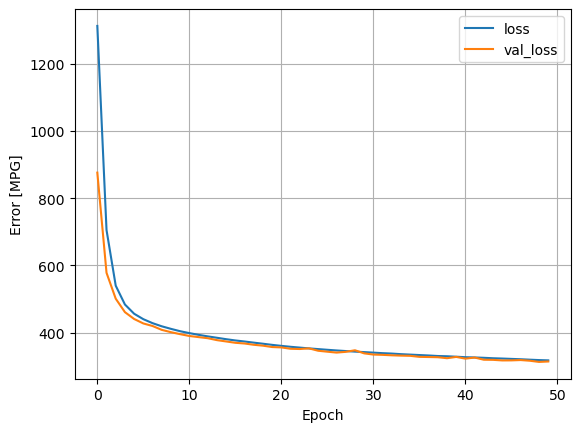

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization) │ (None, 10)             │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,346 (16.98 KB)

 Trainable params: 1,441 (5.63 KB)

 Non-trainable params: 21 (88.00 B)

 Optimizer params: 2,884 (11.27 KB)

None


In [ ]:
fit_params={
    "verbose": 1, 
    "epochs": 50,
    "batch_size": 32,
    "validation_split": 0.2
}

NN_inst.prototyping(fit_params=fit_params)

In [32]:
print(f'metrics:\n{NN_inst.model_metrics}\n')
print(f'best parametrs:\n{NN_inst.best_params}')

metrics:
{'r2': 0.9470371356884407, 'mae': 317.1966276334151, 'rmse': 1586.9337246627078}

best parametrs:
{'parametrs': 0, 'value': 0}


In [ ]:
#NN_inst.train(test_rate=1)

In [ ]:
#NN_inst.model.feature_importances_

In [ ]:
parametr = 'nodes'
'''
It's an Ox' value
(Oy always is a target value --- perfomance)
'''

### fix other params for detail searching
fix_params = {
    'protection': '*',
    'size': '*',
    'op_type': '*',
    'hw_chassis': '*',
    'ssd': '*'
}

NN_inst.compare_graphs(parametr=parametr, fix_params=fix_params, grid=grid_inst, database=db)

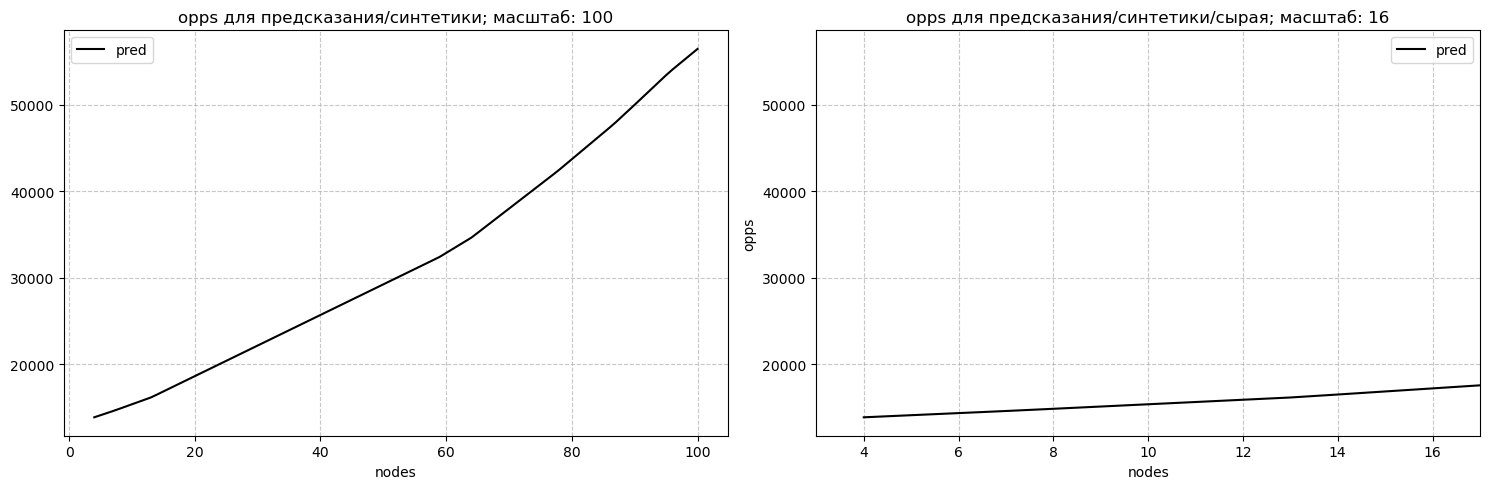

In [4]:
display(Image(filename='demo_graphs/synth_graphs_2.png'))

In [ ]:
parametr = 'nodes'
'''
It's an Ox' value
(Oy always is a target value --- perfomance)
'''

### fix other params for detail searching
fix_params = {
    'protection': '*',
    'size': '*',
    'op_type': '*',
    'hw_chassis': '*',
    'ssd': '*'
}

NN_inst.compare_graphs(parametr=parametr, fix_params=fix_params, grid=grid_inst, database=db)

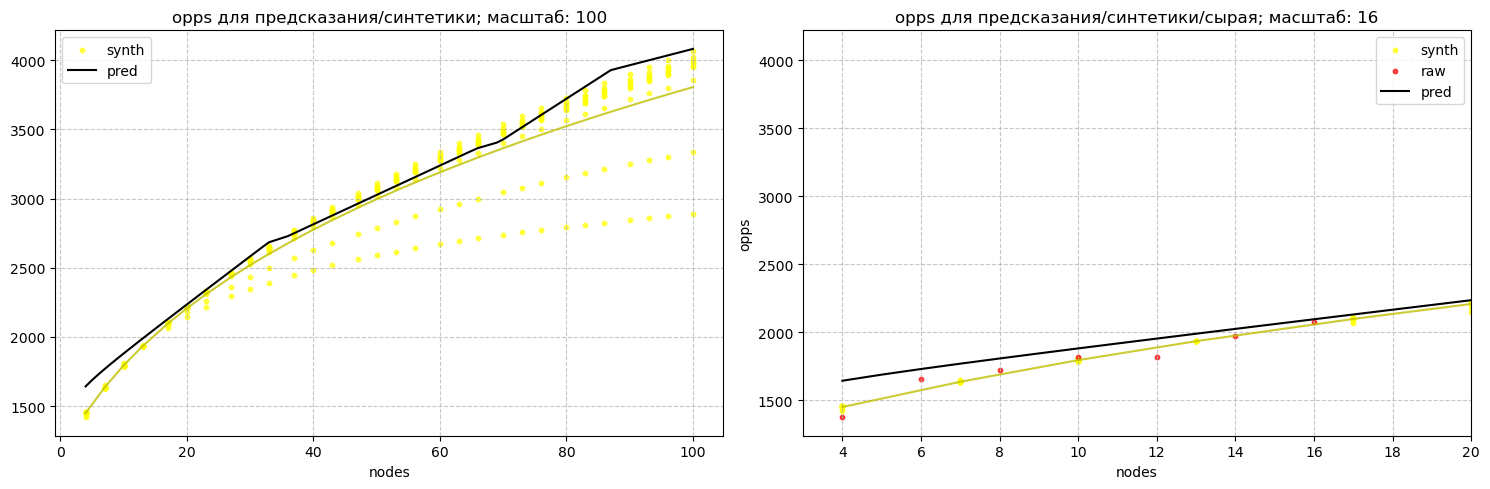

In [5]:
display(Image(filename='demo_graphs/synth_graphs_3.png'))

## Catboost CatBoostRegressor

In [12]:
catboost_inst = modelling.catboost_model(
    n_trials=5, 
    data_df_prototyping=data_df,
    data_df_learn=data_df
    )

created CatBoostRegressor instance
length of prototyping data = 111770
length of learn data = 111770
seed = 42


In [13]:
catboost_inst.prototyping()

[I 2025-04-23 05:09:12,395] A new study created in memory with name: no-name-81d6026f-5527-4bc7-aeb3-ae86c0d375b6


0:	learn: 12764.6550507	test: 12811.8507294	best: 12811.8507294 (0)	total: 369ms	remaining: 9m 37s
1:	learn: 12764.6550507	test: 12811.8507294	best: 12811.8507294 (0)	total: 749ms	remaining: 9m 45s
2:	learn: 12764.6550507	test: 12811.8507294	best: 12811.8507294 (0)	total: 851ms	remaining: 7m 23s
3:	learn: 12764.6550507	test: 12811.8507294	best: 12811.8507294 (3)	total: 969ms	remaining: 6m 18s
4:	learn: 12764.6550507	test: 12811.8507294	best: 12811.8507294 (3)	total: 1.36s	remaining: 7m 4s
5:	learn: 12764.6550507	test: 12811.8507294	best: 12811.8507294 (3)	total: 1.42s	remaining: 6m 10s
6:	learn: 12764.6550507	test: 12811.8507294	best: 12811.8507294 (3)	total: 1.5s	remaining: 5m 33s
7:	learn: 12764.6550507	test: 12811.8507294	best: 12811.8507294 (3)	total: 1.69s	remaining: 5m 28s
8:	learn: 12764.6550507	test: 12811.8507294	best: 12811.8507294 (3)	total: 1.85s	remaining: 5m 20s
9:	learn: 12764.6550507	test: 12811.8507294	best: 12811.8507294 (3)	total: 1.97s	remaining: 5m 5s
10:	learn: 12

[I 2025-04-23 05:21:49,735] Trial 0 finished with value: 5364.612783798619 and parameters: {'iterations': 1566, 'learning_rate': 0.27030921120229173, 'depth': 4, 'early_stopping_rounds': 347, 'model_size_reg': 0.22598989861492813, 'l2_leaf_reg': 0.3949306205105523, 'rsm': 0.011336055612495843}. Best is trial 0 with value: 5364.612783798619.


0:	learn: 11948.5201777	test: 11990.3741175	best: 11990.3741175 (0)	total: 529ms	remaining: 7m 26s
1:	learn: 11280.2943620	test: 11328.0769816	best: 11328.0769816 (1)	total: 903ms	remaining: 6m 20s
2:	learn: 10953.0045978	test: 11002.7031941	best: 11002.7031941 (2)	total: 974ms	remaining: 4m 33s
3:	learn: 10823.1326939	test: 10869.6226878	best: 10869.6226878 (3)	total: 1.21s	remaining: 4m 13s
4:	learn: 10772.7546679	test: 10816.9107257	best: 10816.9107257 (4)	total: 1.31s	remaining: 3m 40s
5:	learn: 10337.5481668	test: 10381.2975918	best: 10381.2975918 (5)	total: 1.38s	remaining: 3m 12s
6:	learn: 9692.7732753	test: 9734.1180760	best: 9734.1180760 (6)	total: 1.69s	remaining: 3m 22s
7:	learn: 9123.2380369	test: 9163.0192980	best: 9163.0192980 (7)	total: 2.09s	remaining: 3m 38s
8:	learn: 8857.4305465	test: 8898.4477222	best: 8898.4477222 (8)	total: 2.24s	remaining: 3m 28s
9:	learn: 8854.4467952	test: 8895.4225917	best: 8895.4225917 (9)	total: 2.29s	remaining: 3m 11s
10:	learn: 8851.835563

[I 2025-04-23 05:40:32,042] Trial 1 finished with value: 507.8090542649273 and parameters: {'iterations': 845, 'learning_rate': 0.06844179549984819, 'depth': 9, 'early_stopping_rounds': 178, 'model_size_reg': 0.6934826906936394, 'l2_leaf_reg': 0.4292548685743588, 'rsm': 0.23099435704025129}. Best is trial 1 with value: 507.8090542649273.


0:	learn: 12291.9195471	test: 12326.1331632	best: 12326.1331632 (0)	total: 380ms	remaining: 5m 7s
1:	learn: 11794.3989031	test: 11830.1295661	best: 11830.1295661 (1)	total: 554ms	remaining: 3m 43s
2:	learn: 11145.4966006	test: 11175.2281682	best: 11175.2281682 (2)	total: 940ms	remaining: 4m 12s
3:	learn: 10495.1005423	test: 10519.2869099	best: 10519.2869099 (3)	total: 1.14s	remaining: 3m 48s
4:	learn: 9965.5576783	test: 9991.0215197	best: 9991.0215197 (4)	total: 1.46s	remaining: 3m 54s
5:	learn: 9650.0926427	test: 9675.0265477	best: 9675.0265477 (5)	total: 1.75s	remaining: 3m 54s
6:	learn: 9156.6256179	test: 9181.9405629	best: 9181.9405629 (6)	total: 2s	remaining: 3m 49s
7:	learn: 8698.7513336	test: 8718.8735605	best: 8718.8735605 (7)	total: 2.37s	remaining: 3m 57s
8:	learn: 8288.9952788	test: 8306.0942920	best: 8306.0942920 (8)	total: 2.69s	remaining: 3m 59s
9:	learn: 7866.8349827	test: 7881.8512884	best: 7881.8512884 (9)	total: 2.89s	remaining: 3m 51s
10:	learn: 7574.2092543	test: 75

[I 2025-04-23 05:52:59,404] Trial 2 finished with value: 622.9035307081018 and parameters: {'iterations': 810, 'learning_rate': 0.06501482455061326, 'depth': 7, 'early_stopping_rounds': 200, 'model_size_reg': 0.6963746607985072, 'l2_leaf_reg': 0.6435562658781547, 'rsm': 0.25596542528494637}. Best is trial 1 with value: 507.8090542649273.


0:	learn: 12366.1846366	test: 12407.4166173	best: 12407.4166173 (0)	total: 789ms	remaining: 5m 44s
1:	learn: 11817.4967698	test: 11862.7384731	best: 11862.7384731 (1)	total: 963ms	remaining: 3m 29s
2:	learn: 11351.8941864	test: 11389.7197947	best: 11389.7197947 (2)	total: 1.34s	remaining: 3m 15s
3:	learn: 10996.2997230	test: 11051.0233169	best: 11051.0233169 (3)	total: 1.75s	remaining: 3m 9s
4:	learn: 10655.6451018	test: 10710.6022091	best: 10710.6022091 (4)	total: 2.02s	remaining: 2m 55s
5:	learn: 10311.4151736	test: 10355.8353694	best: 10355.8353694 (5)	total: 2.3s	remaining: 2m 45s
6:	learn: 10310.5120995	test: 10354.8969675	best: 10354.8969675 (6)	total: 2.35s	remaining: 2m 24s
7:	learn: 10057.6257859	test: 10099.9752141	best: 10099.9752141 (7)	total: 2.45s	remaining: 2m 11s
8:	learn: 9879.0825585	test: 9921.1744424	best: 9921.1744424 (8)	total: 2.59s	remaining: 2m 3s
9:	learn: 9461.4001744	test: 9493.7322805	best: 9493.7322805 (9)	total: 2.82s	remaining: 2m
10:	learn: 9074.3129974

[I 2025-04-23 05:56:29,751] Trial 3 finished with value: 1688.005505155995 and parameters: {'iterations': 438, 'learning_rate': 0.05451519950806724, 'depth': 6, 'early_stopping_rounds': 102, 'model_size_reg': 0.42302421103874244, 'l2_leaf_reg': 0.9535911223566886, 'rsm': 0.16678431997525123}. Best is trial 1 with value: 507.8090542649273.


0:	learn: 10299.9398732	test: 10333.6418859	best: 10333.6418859 (0)	total: 637ms	remaining: 5m 59s
1:	learn: 8333.1764076	test: 8334.9225034	best: 8334.9225034 (1)	total: 1.23s	remaining: 5m 44s
2:	learn: 6781.4906697	test: 6784.4725263	best: 6784.4725263 (2)	total: 1.69s	remaining: 5m 16s
3:	learn: 5611.3992415	test: 5600.2014423	best: 5600.2014423 (3)	total: 2.12s	remaining: 4m 57s
4:	learn: 4692.2630011	test: 4681.6139051	best: 4681.6139051 (4)	total: 2.53s	remaining: 4m 43s
5:	learn: 3972.1483779	test: 3971.5363312	best: 3971.5363312 (5)	total: 2.99s	remaining: 4m 38s
6:	learn: 3481.0373599	test: 3484.1971114	best: 3484.1971114 (6)	total: 3.39s	remaining: 4m 30s
7:	learn: 2945.9061609	test: 2928.9846840	best: 2928.9846840 (7)	total: 3.83s	remaining: 4m 26s
8:	learn: 2492.6404989	test: 2468.4608621	best: 2468.4608621 (8)	total: 4.26s	remaining: 4m 23s
9:	learn: 2156.2274237	test: 2126.1946457	best: 2126.1946457 (9)	total: 4.66s	remaining: 4m 18s
10:	learn: 1860.4981402	test: 1823.13

[I 2025-04-23 06:16:59,019] Trial 4 finished with value: 451.6320046161042 and parameters: {'iterations': 565, 'learning_rate': 0.20647547763159108, 'depth': 10, 'early_stopping_rounds': 156, 'model_size_reg': 0.4457398237149124, 'l2_leaf_reg': 0.7869901899574733, 'rsm': 0.932854515849796}. Best is trial 4 with value: 451.6320046161042.


In [16]:
print(catboost_inst.model_metrics)
print(catboost_inst.best_params)

{'r2': 0.9939986388232487, 'mae': 511.83692547305236, 'rmse': 1476.5102158624918}
{'parametrs': {'iterations': 565, 'learning_rate': 0.20647547763159108, 'depth': 10, 'early_stopping_rounds': 156, 'model_size_reg': 0.4457398237149124, 'l2_leaf_reg': 0.7869901899574733, 'rsm': 0.932854515849796}, 'value': 451.6320046161042}


In [15]:
catboost_inst.train(test_rate=0.2)

0:	learn: 15443.5002709	total: 377ms	remaining: 3m 32s
1:	learn: 12541.1241596	total: 658ms	remaining: 3m 5s
2:	learn: 10231.3004489	total: 940ms	remaining: 2m 56s
3:	learn: 8399.7524686	total: 1.29s	remaining: 3m
4:	learn: 6947.8583714	total: 1.83s	remaining: 3m 24s
5:	learn: 5731.2290883	total: 2.12s	remaining: 3m 17s
6:	learn: 4774.4941424	total: 2.65s	remaining: 3m 31s
7:	learn: 4041.7141319	total: 3.44s	remaining: 3m 59s
8:	learn: 3476.5390433	total: 3.77s	remaining: 3m 53s
9:	learn: 2991.3739376	total: 4.08s	remaining: 3m 46s
10:	learn: 2655.5906957	total: 4.5s	remaining: 3m 46s
11:	learn: 2387.7881492	total: 5.11s	remaining: 3m 55s
12:	learn: 2184.8392560	total: 5.51s	remaining: 3m 53s
13:	learn: 2030.6287635	total: 6.01s	remaining: 3m 56s
14:	learn: 1917.2413140	total: 6.51s	remaining: 3m 58s
15:	learn: 1839.4828635	total: 6.89s	remaining: 3m 56s
16:	learn: 1790.5888697	total: 7.27s	remaining: 3m 54s
17:	learn: 1735.4177620	total: 7.9s	remaining: 4m
18:	learn: 1701.6024129	tota

In [18]:
catboost_inst.model.feature_importances_

array([18.8292144 ,  8.69560394,  3.28557073, 32.94592639,  4.91500182,
        5.88159825, 18.97269356,  6.4743909 ])

In [ ]:
parametr = 'nodes'
'''
It's an Ox' value
(Oy always is a target value --- perfomance)
'''

### fix other params for detail searching
fix_params = {
    'protection': '*',
    'size': '*',
    'op_type': '*',
    'hw_chassis': '*',
    'ssd': '*'
}

catboost_inst.compare_graphs(parametr=parametr, fix_params=fix_params, grid=grid_inst, database=db)

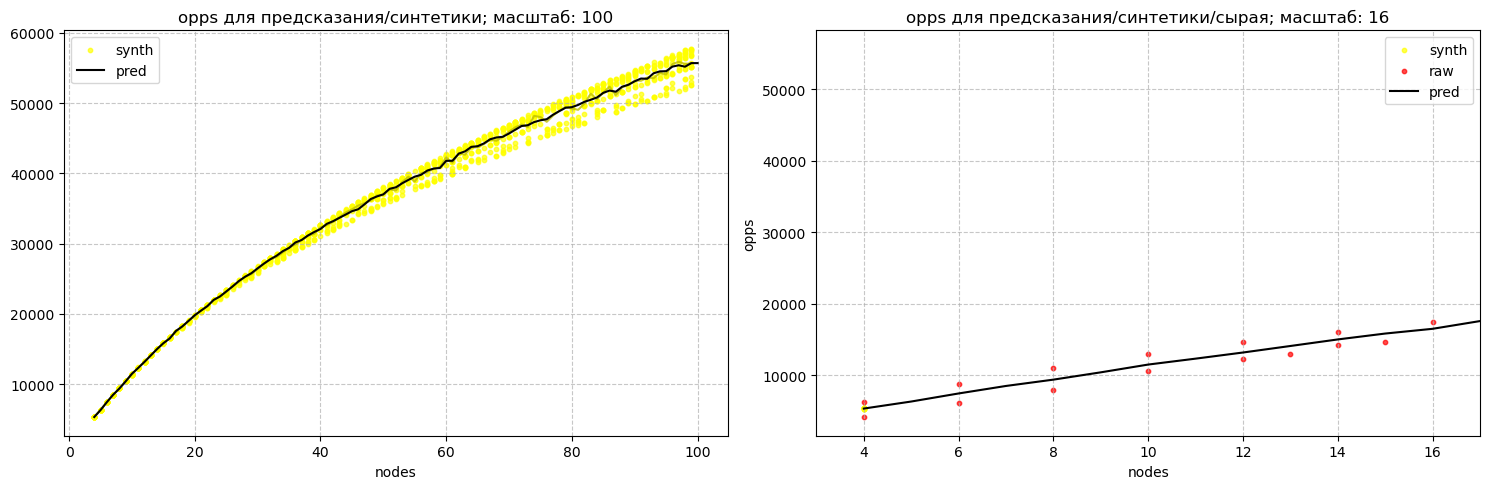

In [6]:
display(Image(filename='demo_graphs/synth_graphs_4.png'))